In [1]:
#데이터셋 로딩
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt

"""
Load AirQualityUCI Data
"""

def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

input_file = './airqu/AirQualityUCI_refined.csv'

df = pd.read_csv(input_file,
                 index_col=[0],
                 parse_dates=[0],
                 date_parser=parser)

df.head()

C:\Users\MASTER\AppData\Local\Temp\ipykernel_33928\2444619694.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,C6H6(GT)
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,11.9
2004-03-10 19:00:00,2.0,1292.0,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,9.4
2004-03-10 20:00:00,2.2,1402.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,9.0
2004-03-10 21:00:00,2.2,1376.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,9.2
2004-03-10 22:00:00,1.6,1272.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,6.5


<AxesSubplot:xlabel='Datetime'>

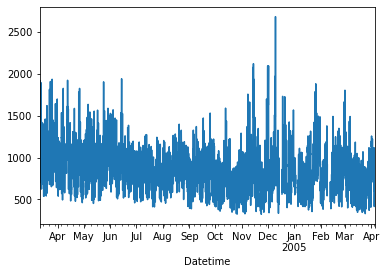

In [3]:
df['PT08.S3(NOx)'].plot() #원본 데이터 플롯

<AxesSubplot:xlabel='Datetime'>

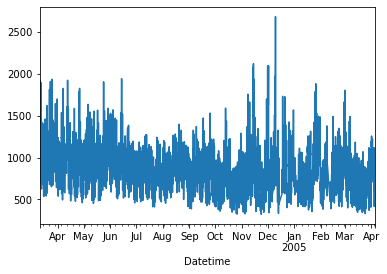

In [7]:
#선형 보간
pt08s3 = df['PT08.S3(NOx)'].copy()
pt08s3.interpolate(inplace=True)
pt08s3.plot()

In [ ]:
#-----------------------------------------------------------------------

In [40]:
#사분위수 범위기반 이상치 탐지
q1 = pt08s3.quantile(0.25)
median = pt08s3.quantile(0.5)
q3 = pt08s3.quantile(0.75)
print(f'q1: {q1},  median: {median},  q3: {q3}')

q1: 654.0,  median: 804.0,  q3: 968.0


In [42]:
iqr = q3-q1
upper_fence = q3 + 1.5*iqr
lower_fence = q1 - 1.5*iqr
print(f'upper fence: {upper_fence},  lower fence: {lower_fence}')

upper fence: 1439.0,  lower fence: 183.0


In [43]:
#.loc 인덱서를 이용한 필터링
outliers = pt08s3.loc[(pt08s3 > upper_fence) | (pt08s3 < lower_fence)]
outliers

Datetime
2004-03-11 00:00:00    1462.0
2004-03-11 01:00:00    1453.0
2004-03-11 02:00:00    1579.0
2004-03-11 03:00:00    1705.0
2004-03-11 04:00:00    1818.0
                        ...  
2005-03-01 03:00:00    1791.0
2005-03-01 04:00:00    1804.0
2005-03-01 05:00:00    1727.0
2005-03-01 06:00:00    1677.0
2005-03-07 04:00:00    1490.0
Name: PT08.S3(NOx), Length: 239, dtype: float64

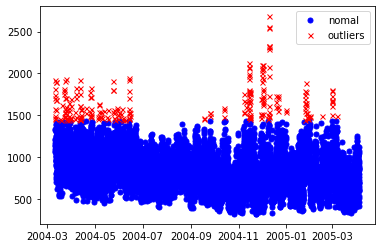

In [44]:
#IQR 이상치 탐지 결과
mask = pt08s3.index.isin(outliers.index)
pt08s3[~mask]

plt.plot(pt08s3[~mask],label='nomal',color='blue',marker='o', markersize=5, linestyle='None')
plt.plot(outliers,label='outliers',color='red',marker='x',markersize=5,linestyle='None')

plt.legend(loc='best')

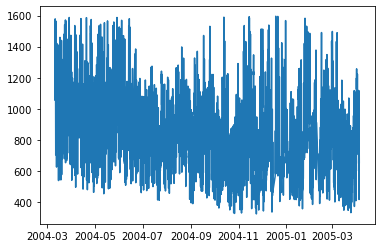

In [34]:
#후처리 - 이상치 제거 후 보간
pt08s3_refined = pt08s3.copy()
pt08s3_refined[mask]=np.nan
pt08s3_refined.interpolate(inplace=True)
plt.plot(pt08s3_refined)

In [ ]:
#-----------------------------------------------------------

C:\Users\MASTER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PT08.S3(NOx)', ylabel='Density'>

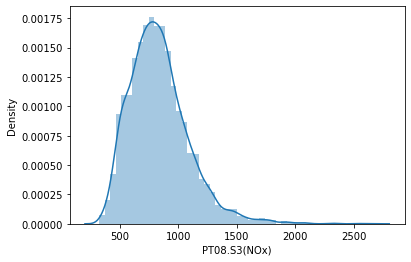

In [11]:
#Z-Score기반 이상치 탐지
import seaborn as sns
sns.distplot(pt08s3)

In [12]:
mean = np.mean(pt08s3)
std = np.std(pt08s3)
print(mean, std)

832.7588970823982 255.69616900657363


In [28]:
#임계치 지정 후 각 데이터에 대한 이상치 여부 판단
outliers = []
thres = 5 # Z-score threshold

for i in pt08s3:
    z_score = (i-mean) / std
    if (np.abs(z_score) > thres):
        print(z_score)
        outliers.append(i)

5.038171310593562
5.8594585469877885
6.751141832215806
5.7147555577183295
7.2360923908485875
5.843814980580279
5.808616956163384
6.684656674983892


In [29]:
outliers = pt08s3.loc[np.abs((pt08s3-mean)/std)>3]
outliers

Datetime
2004-03-11 03:00:00    1705.0
2004-03-11 04:00:00    1818.0
2004-03-11 05:00:00    1918.0
2004-03-11 06:00:00    1738.0
2004-03-12 03:00:00    1680.0
                        ...  
2005-02-28 06:00:00    1665.0
2005-03-01 03:00:00    1791.0
2005-03-01 04:00:00    1804.0
2005-03-01 05:00:00    1727.0
2005-03-01 06:00:00    1677.0
Name: PT08.S3(NOx), Length: 111, dtype: float64

In [30]:
mask = pt08s3.index.isin(outliers.index)
mask[:50]

array([False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

C:\Users\MASTER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MASTER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


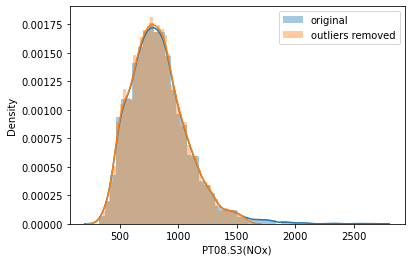

In [31]:
#이상치 제거 후 분포 비교
sns.distplot(pt08s3,axlabel='PT08.S3(NOx)',label='original')
sns.distplot(pt08s3[~mask],label='outliers removed')
plt.legend(loc='best')